### Loading dataset

In [59]:
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
train_df = pd.read_csv('datasets/train/train_emoticon.csv')
valid_df = pd.read_csv('datasets/valid/valid_emoticon.csv')

In [6]:
train_df.head()

,input_emoticon,label
0,😛🛐😻😑😣🙠🙯🚼😒🙼😑🙯😣,0
1,🛐😑😪😛🚼🙯😣🚅😑🙯😹😣🙼,0
2,😛🙯😑🚡😣🚼🛐🙲😣🙯🛑😑🙼,0
3,😛🚼🛐🙐😣🙯😑🙪😑🙼🛆😣🙯,1
4,🛐🚟🚼😛🙋😑😣🙯😹🙯😑😣🙼,1


In [8]:
X_train = train_df.drop('label', axis=1)
y_train = train_df['label']
X_valid = valid_df.drop('label', axis=1)
y_valid = valid_df['label']

### Applying Encoder

In [14]:
# Splitting sequence of emoticons into 13 feature columns
train_emoticon_columns = X_train['input_emoticon'].apply(lambda x: pd.Series(list(x)))
valid_emoticon_columns = X_valid['input_emoticon'].apply(lambda x: pd.Series(list(x)))

In [17]:
# Applying ordinal encoding
encoder = OrdinalEncoder()
train_encoded_emoticons = encoder.fit_transform(train_emoticon_columns)
valid_encoded_emoticons = encoder.fit_transform(valid_emoticon_columns)

# Create a new DataFrame with encoded values
X_train = pd.DataFrame(train_encoded_emoticons, columns=train_emoticon_columns.columns)
X_valid = pd.DataFrame(valid_encoded_emoticons, columns=valid_emoticon_columns.columns)

In [19]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,26.0,197.0,58.0,16.0,34.0,93.0,106.0,178.0,9.0,50.0,8.0,48.0,16.0
1,197.0,16.0,41.0,26.0,178.0,106.0,34.0,125.0,8.0,48.0,27.0,16.0,50.0
2,26.0,106.0,16.0,153.0,34.0,178.0,197.0,109.0,16.0,48.0,83.0,8.0,50.0
3,26.0,178.0,197.0,78.0,34.0,106.0,16.0,102.0,8.0,50.0,77.0,16.0,48.0
4,197.0,151.0,178.0,26.0,73.0,16.0,34.0,106.0,27.0,48.0,8.0,16.0,50.0


### Model

In [25]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

In [27]:
# Train the model on training data
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [29]:
# Predict on the validation set
y_valid_pred = rf_model.predict(X_valid)

In [31]:
valid_accuracy = accuracy_score(y_valid, y_valid_pred)

In [33]:
valid_accuracy

0.49079754601226994

## Using stratified K fold on rf

In [49]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OrdinalEncoder
import numpy as np

# Load the dataset
data = pd.read_csv('datasets/train/train_emoticon.csv')

# Split the dataset into features and target
X = data.drop('label', axis=1)
y = data['label']

# Split 'input_emoticon' into 13 different columns (pad with None if less than 13 characters)
def split_emoticons(emoticon, length=13):
    emoticon_list = list(emoticon)
    # Pad with None (or use a specific placeholder like '-') if shorter than 13
    padded_emoticon_list = emoticon_list + [None] * (length - len(emoticon_list))
    return padded_emoticon_list[:length]  # Return the first 13 elements

# Apply the splitting function to 'input_emoticon'
train_emoticon_columns = X['input_emoticon'].apply(lambda x: pd.Series(split_emoticons(x)))

# Preprocess using Ordinal Encoding for the split emoticon columns
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)  # Handle unknown values if present
X_encoded = encoder.fit_transform(train_emoticon_columns)

# Convert the result back to a DataFrame for compatibility
X_encoded = pd.DataFrame(X_encoded, columns=[f'emoticon_{i}' for i in range(13)])

# Define the model
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Set up Stratified K-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5)
accuracies = []

for train_index, val_index in skf.split(X_encoded, y):
    X_train, X_val = X_encoded.iloc[train_index], X_encoded.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Predict on validation set
    y_pred = model.predict(X_val)
    
    # Calculate accuracy
    acc = accuracy_score(y_val, y_pred)
    accuracies.append(acc)

# Average accuracy across all folds
average_accuracy = sum(accuracies) / len(accuracies)
print(f'Average Accuracy across folds: {average_accuracy:.4f}')

Average Accuracy across folds: 0.5847


In [42]:
X_encoded

array([[1979.],
       [6137.],
       [1566.],
       ...,
       [7039.],
       [2181.],
       [1413.]])

In [51]:
y_valid_pred = model.predict(X_valid)

C:\Users\shash\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [53]:
accuracy_score(y_valid, y_valid_pred)

0.5051124744376279

In [57]:
corr_matrix = X_encoded.corr()

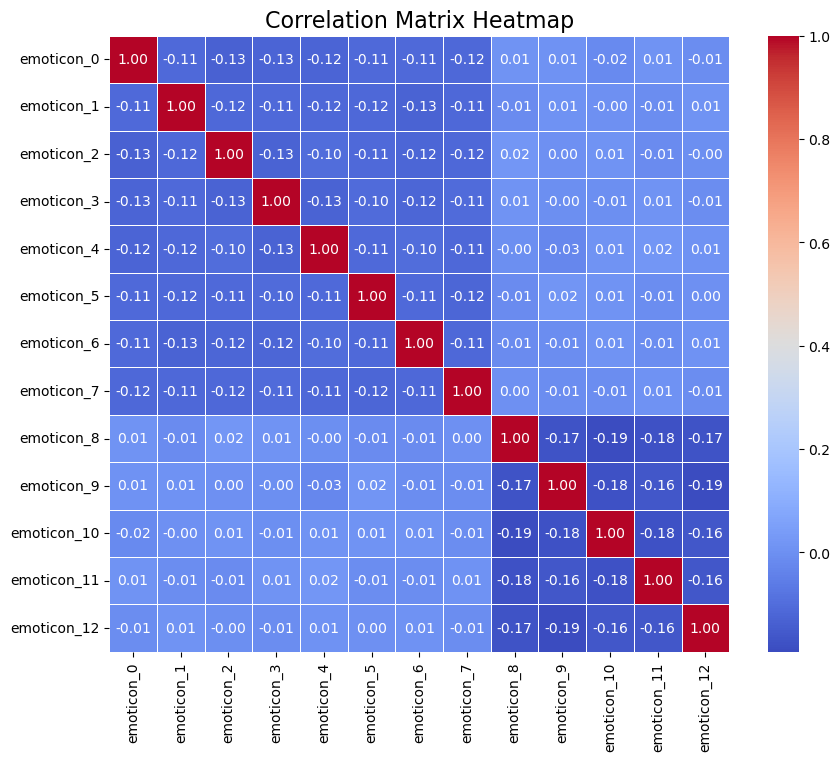

In [61]:
plt.figure(figsize=(10, 8))  # Set the figure size
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

# Add title and labels
plt.title('Correlation Matrix Heatmap', fontsize=16)
plt.show()

In [63]:
variances = X_encoded.var()

# Print variances for each column
for i, var in enumerate(variances):
    print(f"Feature {X_encoded.columns[i]} variance: {var:.4f}")

Feature emoticon_0 variance: 5020.6044
Feature emoticon_1 variance: 4984.5388
Feature emoticon_2 variance: 5044.7059
Feature emoticon_3 variance: 4951.5491
Feature emoticon_4 variance: 5017.2495
Feature emoticon_5 variance: 4974.7288
Feature emoticon_6 variance: 4996.7158
Feature emoticon_7 variance: 4992.8083
Feature emoticon_8 variance: 451.3496
Feature emoticon_9 variance: 451.1862
Feature emoticon_10 variance: 458.7036
Feature emoticon_11 variance: 459.8894
Feature emoticon_12 variance: 461.3587


In [65]:
# Drop low variance features
high_variance_columns = X_encoded.columns[:8]  # Keep the first 8 high-variance features
X_high_variance = X_encoded[high_variance_columns]

# Train the model again with only high-variance features
accuracies = []
for train_index, val_index in skf.split(X_high_variance, y):
    X_train, X_val = X_high_variance.iloc[train_index], X_high_variance.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Predict on validation set
    y_pred = model.predict(X_val)
    
    # Calculate accuracy
    acc = accuracy_score(y_val, y_pred)
    accuracies.append(acc)

# Average accuracy across all folds
average_accuracy = sum(accuracies) / len(accuracies)
print(f'Average Accuracy with high-variance features: {average_accuracy:.4f}')

Average Accuracy with high-variance features: 0.5260


## GBM

In [68]:
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OrdinalEncoder

# Load the dataset
data = pd.read_csv('datasets/train/train_emoticon.csv')

# Split the dataset into features and target
X = data.drop('label', axis=1)
y = data['label']

# Split emoticons into 13 different columns (assuming 'input_emoticon' is a single column with emoticon sequences)
train_emoticon_columns = X['input_emoticon'].apply(lambda x: pd.Series(list(x)))

# Preprocess using Ordinal Encoding
encoder = OrdinalEncoder()
X_encoded = encoder.fit_transform(train_emoticon_columns)
X_encoded = pd.DataFrame(X_encoded, columns=train_emoticon_columns.columns)

# Define the Gradient Boosting model
gbm_model = GradientBoostingClassifier(n_estimators=100, random_state=42)

# Set up Stratified K-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5)
accuracies = []

for train_index, val_index in skf.split(X_encoded, y):
    X_train, X_val = X_encoded.iloc[train_index], X_encoded.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    # Train the GBM model
    gbm_model.fit(X_train, y_train)
    
    # Predict on the validation set
    y_pred = gbm_model.predict(X_val)
    
    # Calculate accuracy
    acc = accuracy_score(y_val, y_pred)
    accuracies.append(acc)

# Average accuracy across all folds
average_accuracy = sum(accuracies) / len(accuracies)
print(f'Average Accuracy across folds: {average_accuracy:.4f}')


Average Accuracy across folds: 0.6229


In [70]:
y_valid_pred = gbm_model.predict(X_valid)

In [72]:
accuracy_score(y_valid, y_valid_pred)

0.49284253578732107

## XGBoost

In [77]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OrdinalEncoder

# Load the dataset
data = pd.read_csv('datasets/train/train_emoticon.csv')

# Split the dataset into features and target
X = data.drop('label', axis=1)
y = data['label']

# Split emoticons into 13 different columns
train_emoticon_columns = X['input_emoticon'].apply(lambda x: pd.Series(list(x)))

# Preprocess using Ordinal Encoding
encoder = OrdinalEncoder()
X_encoded = encoder.fit_transform(train_emoticon_columns)
X_encoded = pd.DataFrame(X_encoded, columns=train_emoticon_columns.columns)

# Define the XGBoost model
xgb_model = XGBClassifier(n_estimators=200, learning_rate=0.05, max_depth=6, random_state=42)

# Set up Stratified K-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5)
accuracies = []

for train_index, val_index in skf.split(X_encoded, y):
    X_train, X_val = X_encoded.iloc[train_index], X_encoded.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    # Train the XGBoost model
    xgb_model.fit(X_train, y_train)
    
    # Predict on validation set
    y_pred = xgb_model.predict(X_val)
    
    # Calculate accuracy
    acc = accuracy_score(y_val, y_pred)
    accuracies.append(acc)

# Average accuracy across all folds
average_accuracy = sum(accuracies) / len(accuracies)
print(f'Average Accuracy with XGBoost: {average_accuracy:.4f}')


Average Accuracy with XGBoost: 0.6271


In [81]:
y_valid_pred = xgb_model.predict(X_valid)
accuracy_score(y_valid, y_valid_pred)

0.4887525562372188

## Word2Vec

In [84]:
!pip install gensim

     ---------------------------------------- 60.3/60.3 kB 3.1 MB/s eta 0:00:00
     ---------------------------------------- 42.5/42.5 MB 5.7 MB/s eta 0:00:00
     ---------------------------------------- 10.4/10.4 MB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 14.8/14.8 MB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for fst-pso: filename=fst_pso-1.8.1-py3-none-any.whl size=20448 sha256=c19b39b49e70d1ad57bb06486e629f622af3126f98fa67c196e1f7bb6735d87d
  Stored in directory: c:\users\shash\appdata\local\pip\cache\wheels\01\02\ee\df0699282986903a384b69aab4413af9efd26b3612b5dccc9e
  Created wheel for miniful: filename=miniful-0.0.6-py3-none-any.whl size=3522 sha256=177126b8e8cecc1979db29985d2cd1386145a1336eb97f1b3136c51adf846a7c
  Stored in directory: c:\users\shash\appdat

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-intel 2.16.1 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.20.3, but you have protobuf 5.27.3 which is incompatible.
pymc3 3.11.6 requires numpy<1.22.2,>=1.15.0, but you have numpy 1.24.4 which is incompatible.
pymc3 3.11.6 requires scipy<1.8.0,>=1.7.3, but you have scipy 1.10.1 which is incompatible.
pymc 5.8.0 requires arviz>=0.13.0, but you have arviz 0.12.1 which is incompatible.
nutpie 0.9.1 requires arviz>=0.15.0, but you have arviz 0.12.1 which is incompatible.
nutpie 0.9.1 requires pandas>=2.0, but you have pandas 1.5.3 which is incompatible.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.24.4 which is incompatible.


In [86]:
import pandas as pd
from gensim.models import Word2Vec
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
import numpy as np

# Load the dataset
data = pd.read_csv('datasets/train/train_emoticon.csv')

# Split the dataset into features and target
X = data.drop('label', axis=1)
y = data['label']

# Split emoticons into 13 different columns
train_emoticon_columns = X['input_emoticon'].apply(lambda x: list(x))

# Step 1: Train Word2Vec model on emoticons
w2v_model = Word2Vec(sentences=train_emoticon_columns, vector_size=50, window=5, min_count=1, sg=1, workers=4, seed=42)

# Function to get the average Word2Vec embedding for each sequence of emoticons
def get_average_word2vec(tokens_list, model, vector_size):
    """Generate average Word2Vec embeddings for a sequence of tokens."""
    embeddings = [model.wv[token] for token in tokens_list if token in model.wv]
    if len(embeddings) == 0:  # Handle case where no tokens are in the vocab
        return np.zeros(vector_size)
    return np.mean(embeddings, axis=0)

# Step 2: Convert the sequences of emoticons into Word2Vec embeddings
X_embedded = np.array([get_average_word2vec(emoticons, w2v_model, vector_size=50) for emoticons in train_emoticon_columns])

# Define the model (Using XGBoost as an example)
xgb_model = XGBClassifier(n_estimators=200, learning_rate=0.05, max_depth=6, random_state=42)

# Step 3: Stratified K-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5)
accuracies = []

for train_index, val_index in skf.split(X_embedded, y):
    X_train, X_val = X_embedded[train_index], X_embedded[val_index]
    y_train, y_val = y[train_index], y[val_index]
    
    # Train the model
    xgb_model.fit(X_train, y_train)
    
    # Predict on validation set
    y_pred = xgb_model.predict(X_val)
    
    # Calculate accuracy
    acc = accuracy_score(y_val, y_pred)
    accuracies.append(acc)

# Average accuracy across all folds
average_accuracy = sum(accuracies) / len(accuracies)
print(f'Average Accuracy with Word2Vec embeddings: {average_accuracy:.4f}')


Average Accuracy with Word2Vec embeddings: 0.4713


## LSTM

In [25]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

# Load training and validation datasets
train_data = pd.read_csv('datasets/train/train_emoticon.csv')
valid_data = pd.read_csv('datasets/valid/valid_emoticon.csv')

# Prepare the input data by splitting the emoticons
def prepare_data(data):
    emoticon_columns = data['input_emoticon'].apply(lambda x: list(x))
    return emoticon_columns

X_train = prepare_data(train_data)
X_valid = prepare_data(valid_data)

y_train = train_data['label']
y_valid = valid_data['label']

# Tokenization
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_valid_seq = tokenizer.texts_to_sequences(X_valid)

# Padding sequences to ensure they have the same length
max_len = 13  # As we have 13 emoticon positions
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_valid_pad = pad_sequences(X_valid_seq, maxlen=max_len, padding='post')

# Encode the labels
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_valid_enc = label_encoder.transform(y_valid)

# LSTM model
vocab_size = len(tokenizer.word_index) + 1  # Vocabulary size (for embedding layer)

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=64, input_length=max_len))
model.add(LSTM(128, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))  # Assuming binary classification

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train_pad, y_train_enc, epochs=10, batch_size=32, validation_data=(X_valid_pad, y_valid_enc))

# Predict on validation set
y_pred = model.predict(X_valid_pad)
y_pred_classes = np.round(y_pred).astype(int)

# Calculate accuracy on validation set
accuracy = accuracy_score(y_valid_enc, y_pred_classes)
print(f'Validation Accuracy: {accuracy:.4f}')


Epoch 1/10


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5568 - loss: 0.6649 - val_accuracy: 0.8916 - val_loss: 0.3020
Epoch 2/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8935 - loss: 0.2691 - val_accuracy: 0.9346 - val_loss: 0.1698
Epoch 3/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9170 - loss: 0.1987 - val_accuracy: 0.9182 - val_loss: 0.1681
Epoch 4/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9361 - loss: 0.1685 - val_accuracy: 0.9407 - val_loss: 0.1309
Epoch 5/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9530 - loss: 0.1283 - val_accuracy: 0.9489 - val_loss: 0.1105
Epoch 6/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9608 - loss: 0.1006 - val_accuracy: 0.9448 - val_loss: 0.1176
Epoch 7/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9639 - loss: 0.0871 - val_accuracy: 0.9407 - val_loss: 0.1343
Epoch 8/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9607 - loss: 0.0932 - val_accuracy: 0.9571 - val_

In [27]:
# Calculate vocabulary size
vocab_size = len(tokenizer.word_index) + 1  # +1 for padding token
print(f'Vocabulary Size: {vocab_size}')  # This will display the vocab size

Vocabulary Size: 215


## SVM

In [94]:
import pandas as pd
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OrdinalEncoder

# Load the training dataset
train_data = pd.read_csv('datasets/train/train_emoticon.csv')

# Load the validation dataset
valid_data = pd.read_csv('datasets/valid/valid_emoticon.csv')

# Prepare the training features and labels
X_train = train_data.drop('label', axis=1)
y_train = train_data['label']

# Prepare the validation features and labels
X_valid = valid_data.drop('label', axis=1)
y_valid = valid_data['label']

# Split each emoticon into separate columns
train_emoticon_columns = X_train['input_emoticon'].apply(lambda x: pd.Series(list(x)))
valid_emoticon_columns = X_valid['input_emoticon'].apply(lambda x: pd.Series(list(x)))

# Apply Ordinal Encoding to the split emoticon columns
encoder = OrdinalEncoder()
X_train_encoded = encoder.fit_transform(train_emoticon_columns)
X_valid_encoded = encoder.transform(valid_emoticon_columns)

# Train the SVM model
model = SVC(kernel='linear', random_state=42)  # You can try different kernels: 'linear', 'rbf', 'poly', etc.
model.fit(X_train_encoded, y_train)

# Predict on the validation set
y_pred = model.predict(X_valid_encoded)

# Calculate accuracy
accuracy = accuracy_score(y_valid, y_pred)
print(f'Accuracy on validation set: {accuracy:.4f}')


Accuracy on validation set: 0.5746


## LSTM hyperparameter tuning

In [4]:
!pip install keras-tuner

     -------------------------------------- 129.1/129.1 kB 2.5 MB/s eta 0:00:00


In [14]:
!pip install tensorflow keras scikit-learn

     -------------------------------------- 413.4/413.4 kB 5.2 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.27.3
    Uninstalling protobuf-5.27.3:
      Successfully uninstalled protobuf-5.27.3


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\shash\\anaconda3\\Lib\\site-packages\\google\\~-pb\\_message.pyd'
Consider using the `--user` option or check the permissions.



In [20]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam, RMSprop

# Function to create and compile the LSTM model
def create_model(lstm_units, dropout_rate, optimizer_choice, learning_rate):
    # Input shape is set based on X_train data shape
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1], 1)))  # Assuming input shape (timesteps, features)
    
    # Add LSTM layer ensuring trainable parameters < 10,000
    model.add(LSTM(units=lstm_units, return_sequences=False))
    model.add(Dropout(dropout_rate))
    
    # Output layer with single neuron for binary classification
    model.add(Dense(1, activation='sigmoid'))  # Binary classification
    
    # Compile model with selected optimizer and learning rate
    optimizer = optimizer_choice(learning_rate=learning_rate)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model

# Hyperparameter search space
lstm_units_list = [16, 32]  # Adjusted units to stay within parameter limit
dropout_rates = [0.2, 0.4]
optimizers = [Adam, RMSprop]
learning_rates = [0.001, 0.0001]
batch_sizes = [32, 64]
epochs_list = [10, 20]

# Best hyperparameters tracking
best_accuracy = 0
best_params = None

# Loop over all combinations of hyperparameters
for lstm_units in lstm_units_list:
    for dropout_rate in dropout_rates:
        for optimizer_choice in optimizers:
            for learning_rate in learning_rates:
                for batch_size in batch_sizes:
                    for epochs in epochs_list:
                        # Create and train the model
                        model = create_model(lstm_units, dropout_rate, optimizer_choice, learning_rate)
                        
                        # Check the number of parameters
                        total_params = model.count_params()
                        if total_params > 10000:
                            print(f"Skipping: units={lstm_units}, total_params={total_params} (exceeds limit)")
                            continue
                        
                        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
                        
                        # Evaluate the model on the validation set
                        val_loss, val_accuracy = model.evaluate(X_valid, y_valid, verbose=0)
                        
                        # Check if this is the best accuracy so far
                        if val_accuracy > best_accuracy:
                            best_accuracy = val_accuracy
                            best_params = {
                                'lstm_units': lstm_units,
                                'dropout_rate': dropout_rate,
                                'optimizer_choice': optimizer_choice.__name__,
                                'learning_rate': learning_rate,
                                'batch_size': batch_size,
                                'epochs': epochs
                            }
                        
                        # Print current hyperparameter set and accuracy
                        print(f"Params: units={lstm_units}, dropout={dropout_rate}, optimizer={optimizer_choice.__name__}, lr={learning_rate}, batch={batch_size}, epochs={epochs}, params={total_params}")
                        print(f"Validation Accuracy: {val_accuracy:.4f}\n")

# Output the best parameters and accuracy
print(f"Best params: {best_params}")
print(f"Best accuracy: {best_accuracy:.4f}")


UnimplementedError: Graph execution error:

Detected at node sequential_1_1/Cast defined at (most recent call last):
  File "C:\Users\shash\anaconda3\lib\runpy.py", line 196, in _run_module_as_main

  File "C:\Users\shash\anaconda3\lib\runpy.py", line 86, in _run_code

  File "C:\Users\shash\anaconda3\lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\shash\anaconda3\lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\shash\anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\shash\anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 205, in start

  File "C:\Users\shash\anaconda3\lib\asyncio\base_events.py", line 603, in run_forever

  File "C:\Users\shash\anaconda3\lib\asyncio\base_events.py", line 1909, in _run_once

  File "C:\Users\shash\anaconda3\lib\asyncio\events.py", line 80, in _run

  File "C:\Users\shash\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue

  File "C:\Users\shash\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one

  File "C:\Users\shash\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell

  File "C:\Users\shash\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 729, in execute_request

  File "C:\Users\shash\anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 411, in do_execute

  File "C:\Users\shash\anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 531, in run_cell

  File "C:\Users\shash\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3009, in run_cell

  File "C:\Users\shash\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3064, in _run_cell

  File "C:\Users\shash\anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner

  File "C:\Users\shash\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3269, in run_cell_async

  File "C:\Users\shash\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3448, in run_ast_nodes

  File "C:\Users\shash\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code

  File "C:\Users\shash\AppData\Local\Temp\ipykernel_23772\1457382978.py", line 53, in <module>

  File "C:\Users\shash\anaconda3\lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "C:\Users\shash\anaconda3\lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 318, in fit

  File "C:\Users\shash\anaconda3\lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 121, in one_step_on_iterator

  File "C:\Users\shash\anaconda3\lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 108, in one_step_on_data

  File "C:\Users\shash\anaconda3\lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 51, in train_step

  File "C:\Users\shash\anaconda3\lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\layer.py", line 882, in __call__

  File "C:\Users\shash\anaconda3\lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "C:\Users\shash\anaconda3\lib\site-packages\keras\src\ops\operation.py", line 46, in __call__

  File "C:\Users\shash\anaconda3\lib\site-packages\keras\src\utils\traceback_utils.py", line 156, in error_handler

  File "C:\Users\shash\anaconda3\lib\site-packages\keras\src\models\sequential.py", line 209, in call

  File "C:\Users\shash\anaconda3\lib\site-packages\keras\src\models\functional.py", line 167, in call

  File "C:\Users\shash\anaconda3\lib\site-packages\keras\src\models\functional.py", line 258, in _standardize_inputs

  File "C:\Users\shash\anaconda3\lib\site-packages\keras\src\models\functional.py", line 218, in _convert_inputs_to_tensors

  File "C:\Users\shash\anaconda3\lib\site-packages\keras\src\ops\core.py", line 743, in convert_to_tensor

  File "C:\Users\shash\anaconda3\lib\site-packages\keras\src\backend\tensorflow\core.py", line 120, in convert_to_tensor

Cast string to float is not supported
	 [[{{node sequential_1_1/Cast}}]] [Op:__inference_one_step_on_iterator_4608]

## LSTM with trainable parameters less than 10000

In [23]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

# Load training and validation datasets
train_data = pd.read_csv('datasets/train/train_emoticon.csv')
valid_data = pd.read_csv('datasets/valid/valid_emoticon.csv')

# Prepare the input data by splitting the emoticons
def prepare_data(data):
    emoticon_columns = data['input_emoticon'].apply(lambda x: list(x))
    return emoticon_columns

X_train = prepare_data(train_data)
X_valid = prepare_data(valid_data)

y_train = train_data['label']
y_valid = valid_data['label']

# Tokenization
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(X_train)

# Calculate vocabulary size
vocab_size = len(tokenizer.word_index) + 1  # +1 for padding token
print(f'Vocabulary Size: {vocab_size}')  # This will display the vocab size

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_valid_seq = tokenizer.texts_to_sequences(X_valid)

# Padding sequences to ensure they have the same length
max_len = 13  # As we have 13 emoticon positions
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_valid_pad = pad_sequences(X_valid_seq, maxlen=max_len, padding='post')

# Encode the labels
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_valid_enc = label_encoder.transform(y_valid)

# LSTM model
vocab_size = len(tokenizer.word_index) + 1  # Vocabulary size (for embedding layer)

# Adjusted parameters
embedding_dim = 8  # Reduced embedding dimension
lstm_units = 16    # Reduced LSTM units
dense_units = 8     # Reduced Dense units

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len))
model.add(LSTM(lstm_units, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(dense_units, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))  # Assuming binary classification

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train_pad, y_train_enc, epochs=10, batch_size=32, validation_data=(X_valid_pad, y_valid_enc))

# Predict on validation set
y_pred = model.predict(X_valid_pad)
y_pred_classes = np.round(y_pred).astype(int)

# Calculate accuracy on validation set
accuracy = accuracy_score(y_valid_enc, y_pred_classes)
print(f'Validation Accuracy: {accuracy:.4f}')


Vocabulary Size: 215
Epoch 1/10


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5144 - loss: 0.6932 - val_accuracy: 0.5910 - val_loss: 0.6907
Epoch 2/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5943 - loss: 0.6692 - val_accuracy: 0.8650 - val_loss: 0.3610
Epoch 3/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7997 - loss: 0.4183 - val_accuracy: 0.9080 - val_loss: 0.2514
Epoch 4/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8712 - loss: 0.3288 - val_accuracy: 0.8998 - val_loss: 0.2381
Epoch 5/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8880 - loss: 0.3011 - val_accuracy: 0.9162 - val_loss: 0.2157
Epoch 6/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8923 - loss: 0.2775 - val_accuracy: 0.9243 - val_loss: 0.1959
Epoch 7/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8969 - loss: 0.2515 - val_accuracy: 0.9162 - val_loss: 0.1919
Epoch 8/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9108 - loss: 0.2342 - val_accuracy: 0.9202 - val_

## LSTM with params < 10000 hyperparams tuning

In [70]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.metrics import accuracy_score

# Load training and validation datasets
train_data = pd.read_csv('datasets/train/train_emoticon.csv')
valid_data = pd.read_csv('datasets/valid/valid_emoticon.csv')

# Prepare the input data by splitting the emoticons
def prepare_data(data):
    emoticon_columns = data['input_emoticon'].apply(lambda x: list(x))
    return emoticon_columns

X_train = prepare_data(train_data)
X_valid = prepare_data(valid_data)

y_train = train_data['label']
y_valid = valid_data['label']

# Tokenization
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(X_train)

# Vocabulary size
vocab_size = len(tokenizer.word_index) + 1

# Padding sequences
max_len = 13  # As we have 13 emoticon positions
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_valid_seq = tokenizer.texts_to_sequences(X_valid)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_valid_pad = pad_sequences(X_valid_seq, maxlen=max_len, padding='post')

# Assign y values directly
y_train_enc = y_train  # Already binary
y_valid_enc = y_valid  # Already binary

# Function to create and compile the model
def create_model(lstm_units, dense_units, dropout_rate):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=32, input_length=max_len))
    model.add(LSTM(lstm_units, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))  # Assuming binary classification
    
    # Build the model to ensure all layers are initialized
    model.build(input_shape=(None, max_len))  # Use batch size as None
    
    # Calculate total trainable parameters
    total_params = model.count_params()
    print(f'Total Trainable Parameters: {total_params}')

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Hyperparameter tuning
lstm_units_options = [16, 32, 64]  # Added 16
dense_units_options = [16, 32, 64]  # Added 16
dropout_rates = [0.2, 0.3, 0.5]
best_accuracy = 0
best_params = {}

for lstm_units in lstm_units_options:
    for dense_units in dense_units_options:
        for dropout_rate in dropout_rates:
            model = create_model(lstm_units, dense_units, dropout_rate)
            model.fit(X_train_pad, y_train_enc, epochs=10, batch_size=32, validation_data=(X_valid_pad, y_valid_enc), verbose=0)

            # Predict on validation set
            y_pred = model.predict(X_valid_pad)
            y_pred_classes = np.round(y_pred).astype(int)

            # Calculate accuracy
            accuracy = accuracy_score(y_valid_enc, y_pred_classes)
            print(f'Accuracy: {accuracy:.4f} | LSTM Units: {lstm_units}, Dense Units: {dense_units}, Dropout Rate: {dropout_rate}')

            # Check if this is the best model
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_params = {
                    'lstm_units': lstm_units,
                    'dense_units': dense_units,
                    'dropout_rate': dropout_rate
                }

print(f'Best Accuracy: {best_accuracy:.4f} | Best Params: {best_params}')


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Total Trainable Parameters: 10305
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Accuracy: 0.9305 | LSTM Units: 16, Dense Units: 16, Dropout Rate: 0.2
Total Trainable Parameters: 10305


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Accuracy: 0.9448 | LSTM Units: 16, Dense Units: 16, Dropout Rate: 0.3
Total Trainable Parameters: 10305


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Accuracy: 0.9202 | LSTM Units: 16, Dense Units: 16, Dropout Rate: 0.5
Total Trainable Parameters: 10593


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Accuracy: 0.9325 | LSTM Units: 16, Dense Units: 32, Dropout Rate: 0.2
Total Trainable Parameters: 10593


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Accuracy: 0.9325 | LSTM Units: 16, Dense Units: 32, Dropout Rate: 0.3
Total Trainable Parameters: 10593


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Accuracy: 0.9346 | LSTM Units: 16, Dense Units: 32, Dropout Rate: 0.5
Total Trainable Parameters: 11169


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Accuracy: 0.9284 | LSTM Units: 16, Dense Units: 64, Dropout Rate: 0.2
Total Trainable Parameters: 11169


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Accuracy: 0.9509 | LSTM Units: 16, Dense Units: 64, Dropout Rate: 0.3
Total Trainable Parameters: 11169


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Accuracy: 0.9182 | LSTM Units: 16, Dense Units: 64, Dropout Rate: 0.5
Total Trainable Parameters: 15745


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Accuracy: 0.9550 | LSTM Units: 32, Dense Units: 16, Dropout Rate: 0.2
Total Trainable Parameters: 15745


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Accuracy: 0.9448 | LSTM Units: 32, Dense Units: 16, Dropout Rate: 0.3
Total Trainable Parameters: 15745


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Accuracy: 0.9489 | LSTM Units: 32, Dense Units: 16, Dropout Rate: 0.5
Total Trainable Parameters: 16289


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Accuracy: 0.9530 | LSTM Units: 32, Dense Units: 32, Dropout Rate: 0.2
Total Trainable Parameters: 16289


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Accuracy: 0.9448 | LSTM Units: 32, Dense Units: 32, Dropout Rate: 0.3
Total Trainable Parameters: 16289


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Accuracy: 0.9448 | LSTM Units: 32, Dense Units: 32, Dropout Rate: 0.5
Total Trainable Parameters: 17377


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Accuracy: 0.9530 | LSTM Units: 32, Dense Units: 64, Dropout Rate: 0.2
Total Trainable Parameters: 17377


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Accuracy: 0.9427 | LSTM Units: 32, Dense Units: 64, Dropout Rate: 0.3
Total Trainable Parameters: 17377


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Accuracy: 0.9550 | LSTM Units: 32, Dense Units: 64, Dropout Rate: 0.5
Total Trainable Parameters: 32769


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Accuracy: 0.9509 | LSTM Units: 64, Dense Units: 16, Dropout Rate: 0.2
Total Trainable Parameters: 32769


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Accuracy: 0.9632 | LSTM Units: 64, Dense Units: 16, Dropout Rate: 0.3
Total Trainable Parameters: 32769


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Accuracy: 0.9407 | LSTM Units: 64, Dense Units: 16, Dropout Rate: 0.5
Total Trainable Parameters: 33825


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Accuracy: 0.9550 | LSTM Units: 64, Dense Units: 32, Dropout Rate: 0.2
Total Trainable Parameters: 33825


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Accuracy: 0.9611 | LSTM Units: 64, Dense Units: 32, Dropout Rate: 0.3
Total Trainable Parameters: 33825


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Accuracy: 0.9611 | LSTM Units: 64, Dense Units: 32, Dropout Rate: 0.5
Total Trainable Parameters: 35937


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Accuracy: 0.9652 | LSTM Units: 64, Dense Units: 64, Dropout Rate: 0.2
Total Trainable Parameters: 35937


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Accuracy: 0.9387 | LSTM Units: 64, Dense Units: 64, Dropout Rate: 0.3
Total Trainable Parameters: 35937


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Accuracy: 0.9591 | LSTM Units: 64, Dense Units: 64, Dropout Rate: 0.5
Best Accuracy: 0.9652 | Best Params: {'lstm_units': 64, 'dense_units': 64, 'dropout_rate': 0.2}


# Final code for dataset 1

In [122]:
from tensorflow.keras.layers import SimpleRNN

# Function to create and compile the model
def create_model(lstm_units, dense_units, dropout_rate):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=8, input_length=max_len))
    model.add(SimpleRNN(lstm_units, return_sequences=False))  # Use SimpleRNN to reduce params
    model.add(Dropout(dropout_rate))
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))  # Assuming binary classification
    
    # Build the model to ensure all layers are initialized
    model.build(input_shape=(None, max_len))  # Use batch size as None
    
    # Calculate total trainable parameters
    total_params = model.count_params()
    print(f'Total Trainable Parameters: {total_params}')

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Hyperparameter tuning with reduced options
lstm_units_options = [56]  # Reduced LSTM units
dense_units_options = [56]  # Reduced Dense units
dropout_rates = [0.3]  # Keep one dropout rate for simplicity
best_accuracy = 0
best_params = {}

for lstm_units in lstm_units_options:
    for dense_units in dense_units_options:
        for dropout_rate in dropout_rates:
            model = create_model(lstm_units, dense_units, dropout_rate)
            model.fit(X_train_pad, y_train_enc, epochs=10, batch_size=32, validation_data=(X_valid_pad, y_valid_enc), verbose=0)

            # Predict on validation set
            y_pred = model.predict(X_valid_pad)
            y_pred_classes = np.round(y_pred).astype(int)

            # Calculate accuracy
            accuracy = accuracy_score(y_valid_enc, y_pred_classes)
            print(f'Accuracy: {accuracy:.4f} | LSTM Units: {lstm_units}, Dense Units: {dense_units}, Dropout Rate: {dropout_rate}')

            # Check if this is the best model
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_params = {
                    'lstm_units': lstm_units,
                    'dense_units': dense_units,
                    'dropout_rate': dropout_rate
                }

print(f'Best Accuracy: {best_accuracy:.4f} | Best Params: {best_params}')


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Total Trainable Parameters: 8609
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Accuracy: 0.9775 | LSTM Units: 56, Dense Units: 56, Dropout Rate: 0.3
Best Accuracy: 0.9775 | Best Params: {'lstm_units': 56, 'dense_units': 56, 'dropout_rate': 0.3}


In [72]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout
from sklearn.metrics import accuracy_score

# Load training and validation datasets
train_data = pd.read_csv('datasets/train/train_emoticon.csv')
valid_data = pd.read_csv('datasets/valid/valid_emoticon.csv')

# Prepare the input data by splitting the emoticons
def prepare_data(data):
    emoticon_columns = data['input_emoticon'].apply(lambda x: list(x))
    return emoticon_columns

X_train = prepare_data(train_data)
X_valid = prepare_data(valid_data)

y_train = train_data['label']
y_valid = valid_data['label']

# Tokenization
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(X_train)

# Vocabulary size
vocab_size = len(tokenizer.word_index) + 1

# Padding sequences
max_len = 13  # As we have 13 emoticon positions
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_valid_seq = tokenizer.texts_to_sequences(X_valid)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_valid_pad = pad_sequences(X_valid_seq, maxlen=max_len, padding='post')

# Assign y values directly
y_train_enc = y_train  # Already binary
y_valid_enc = y_valid  # Already binary

# Function to create and compile the model
def create_model(lstm_units, dense_units, dropout_rate):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=16, input_length=max_len))  # Reduced output dimension
    model.add(GRU(lstm_units))  # Use GRU instead of LSTM
    model.add(Dropout(dropout_rate))
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))  # Assuming binary classification
    
    # Build the model to ensure all layers are initialized
    model.build(input_shape=(None, max_len))  # Use batch size as None
    
    # Calculate total trainable parameters
    total_params = model.count_params()
    print(f'Total Trainable Parameters: {total_params}')

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Hyperparameter tuning
lstm_units_options = [8, 16]  # Reduced options
dense_units_options = [8, 16]  # Reduced options
dropout_rates = [0.2, 0.3]
best_accuracy = 0
best_params = {}

for lstm_units in lstm_units_options:
    for dense_units in dense_units_options:
        for dropout_rate in dropout_rates:
            model = create_model(lstm_units, dense_units, dropout_rate)
            model.fit(X_train_pad, y_train_enc, epochs=10, batch_size=32, validation_data=(X_valid_pad, y_valid_enc), verbose=0)

            # Predict on validation set
            y_pred = model.predict(X_valid_pad)
            y_pred_classes = np.round(y_pred).astype(int)

            # Calculate accuracy
            accuracy = accuracy_score(y_valid_enc, y_pred_classes)
            print(f'Accuracy: {accuracy:.4f} | LSTM Units: {lstm_units}, Dense Units: {dense_units}, Dropout Rate: {dropout_rate}')

            # Check if this is the best model
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_params = {
                    'lstm_units': lstm_units,
                    'dense_units': dense_units,
                    'dropout_rate': dropout_rate
                }

print(f'Best Accuracy: {best_accuracy:.4f} | Best Params: {best_params}')


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Total Trainable Parameters: 4145
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
Accuracy: 0.9080 | LSTM Units: 8, Dense Units: 8, Dropout Rate: 0.2
Total Trainable Parameters: 4145


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Accuracy: 0.9305 | LSTM Units: 8, Dense Units: 8, Dropout Rate: 0.3
Total Trainable Parameters: 4225


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Accuracy: 0.8998 | LSTM Units: 8, Dense Units: 16, Dropout Rate: 0.2
Total Trainable Parameters: 4225


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
Accuracy: 0.9284 | LSTM Units: 8, Dense Units: 16, Dropout Rate: 0.3
Total Trainable Parameters: 5217


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Accuracy: 0.9305 | LSTM Units: 16, Dense Units: 8, Dropout Rate: 0.2
Total Trainable Parameters: 5217


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
Accuracy: 0.9243 | LSTM Units: 16, Dense Units: 8, Dropout Rate: 0.3
Total Trainable Parameters: 5361


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Accuracy: 0.9100 | LSTM Units: 16, Dense Units: 16, Dropout Rate: 0.2
Total Trainable Parameters: 5361


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
Accuracy: 0.9202 | LSTM Units: 16, Dense Units: 16, Dropout Rate: 0.3
Best Accuracy: 0.9305 | Best Params: {'lstm_units': 8, 'dense_units': 8, 'dropout_rate': 0.3}


In [74]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout
from tensorflow.keras.regularizers import l1, l2
from sklearn.metrics import accuracy_score

# Load training and validation datasets
train_data = pd.read_csv('datasets/train/train_emoticon.csv')
valid_data = pd.read_csv('datasets/valid/valid_emoticon.csv')

# Prepare the input data by splitting the emoticons
def prepare_data(data):
    emoticon_columns = data['input_emoticon'].apply(lambda x: list(x))
    return emoticon_columns

X_train = prepare_data(train_data)
X_valid = prepare_data(valid_data)

y_train = train_data['label']
y_valid = valid_data['label']

# Tokenization
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(X_train)

# Vocabulary size
vocab_size = len(tokenizer.word_index) + 1

# Padding sequences
max_len = 13  # As we have 13 emoticon positions
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_valid_seq = tokenizer.texts_to_sequences(X_valid)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_valid_pad = pad_sequences(X_valid_seq, maxlen=max_len, padding='post')

# Assign y values directly
y_train_enc = y_train  # Already binary
y_valid_enc = y_valid  # Already binary

# Function to create and compile the model
def create_model(lstm_units, dense_units, dropout_rate, reg_type=None, reg_param=0.01):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=32, input_length=max_len))  # Reduced output dimension
    model.add(GRU(lstm_units, kernel_regularizer=reg_type(reg_param) if reg_type else None))  # Apply regularization to GRU
    model.add(Dropout(dropout_rate))
    model.add(Dense(dense_units, activation='relu', kernel_regularizer=reg_type(reg_param) if reg_type else None))  # Apply regularization to Dense
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))  # Assuming binary classification
    
    # Build the model to ensure all layers are initialized
    model.build(input_shape=(None, max_len))  # Use batch size as None
    
    # Calculate total trainable parameters
    total_params = model.count_params()
    print(f'Total Trainable Parameters: {total_params}')

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Hyperparameter tuning
lstm_units_options = [8, 16, 32, 64]  # Reduced options
dense_units_options = [8, 16, 32, 64]  # Reduced options
dropout_rates = [0.2, 0.3]
regularizers = [(l1, 0.01), (l2, 0.01), (None, None)]  # Regularization options
best_accuracy = 0
best_params = {}

for lstm_units in lstm_units_options:
    for dense_units in dense_units_options:
        for dropout_rate in dropout_rates:
            for reg_type, reg_param in regularizers:
                model = create_model(lstm_units, dense_units, dropout_rate, reg_type, reg_param)
                model.fit(X_train_pad, y_train_enc, epochs=10, batch_size=32, validation_data=(X_valid_pad, y_valid_enc), verbose=0)

                # Predict on validation set
                y_pred = model.predict(X_valid_pad)
                y_pred_classes = np.round(y_pred).astype(int)

                # Calculate accuracy
                accuracy = accuracy_score(y_valid_enc, y_pred_classes)
                print(f'Accuracy: {accuracy:.4f} | LSTM Units: {lstm_units}, Dense Units: {dense_units}, Dropout Rate: {dropout_rate}, Reg: {reg_type.__name__ if reg_type else "None"}')

                # Check if this is the best model
                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    best_params = {
                        'lstm_units': lstm_units,
                        'dense_units': dense_units,
                        'dropout_rate': dropout_rate,
                        'reg_type': reg_type.__name__ if reg_type else "None",
                        'reg_param': reg_param
                    }

print(f'Best Accuracy: {best_accuracy:.4f} | Best Params: {best_params}')


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Total Trainable Parameters: 7969
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
Accuracy: 0.5153 | LSTM Units: 8, Dense Units: 8, Dropout Rate: 0.2, Reg: L1
Total Trainable Parameters: 7969


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Accuracy: 0.9223 | LSTM Units: 8, Dense Units: 8, Dropout Rate: 0.2, Reg: L2
Total Trainable Parameters: 7969


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
Accuracy: 0.9264 | LSTM Units: 8, Dense Units: 8, Dropout Rate: 0.2, Reg: None
Total Trainable Parameters: 7969


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Accuracy: 0.5153 | LSTM Units: 8, Dense Units: 8, Dropout Rate: 0.3, Reg: L1
Total Trainable Parameters: 7969


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
Accuracy: 0.9182 | LSTM Units: 8, Dense Units: 8, Dropout Rate: 0.3, Reg: L2
Total Trainable Parameters: 7969


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Accuracy: 0.9387 | LSTM Units: 8, Dense Units: 8, Dropout Rate: 0.3, Reg: None
Total Trainable Parameters: 8049


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Accuracy: 0.5153 | LSTM Units: 8, Dense Units: 16, Dropout Rate: 0.2, Reg: L1
Total Trainable Parameters: 8049


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Accuracy: 0.9346 | LSTM Units: 8, Dense Units: 16, Dropout Rate: 0.2, Reg: L2
Total Trainable Parameters: 8049


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Accuracy: 0.9325 | LSTM Units: 8, Dense Units: 16, Dropout Rate: 0.2, Reg: None
Total Trainable Parameters: 8049


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Accuracy: 0.5153 | LSTM Units: 8, Dense Units: 16, Dropout Rate: 0.3, Reg: L1
Total Trainable Parameters: 8049


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Accuracy: 0.9223 | LSTM Units: 8, Dense Units: 16, Dropout Rate: 0.3, Reg: L2
Total Trainable Parameters: 8049


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Accuracy: 0.9039 | LSTM Units: 8, Dense Units: 16, Dropout Rate: 0.3, Reg: None
Total Trainable Parameters: 8209


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Accuracy: 0.5153 | LSTM Units: 8, Dense Units: 32, Dropout Rate: 0.2, Reg: L1
Total Trainable Parameters: 8209


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Accuracy: 0.9141 | LSTM Units: 8, Dense Units: 32, Dropout Rate: 0.2, Reg: L2
Total Trainable Parameters: 8209


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
Accuracy: 0.9182 | LSTM Units: 8, Dense Units: 32, Dropout Rate: 0.2, Reg: None
Total Trainable Parameters: 8209


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Accuracy: 0.5153 | LSTM Units: 8, Dense Units: 32, Dropout Rate: 0.3, Reg: L1
Total Trainable Parameters: 8209


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Accuracy: 0.8957 | LSTM Units: 8, Dense Units: 32, Dropout Rate: 0.3, Reg: L2
Total Trainable Parameters: 8209


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Accuracy: 0.9162 | LSTM Units: 8, Dense Units: 32, Dropout Rate: 0.3, Reg: None
Total Trainable Parameters: 8529


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Accuracy: 0.5153 | LSTM Units: 8, Dense Units: 64, Dropout Rate: 0.2, Reg: L1
Total Trainable Parameters: 8529


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Accuracy: 0.9284 | LSTM Units: 8, Dense Units: 64, Dropout Rate: 0.2, Reg: L2
Total Trainable Parameters: 8529


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
Accuracy: 0.9182 | LSTM Units: 8, Dense Units: 64, Dropout Rate: 0.2, Reg: None
Total Trainable Parameters: 8529


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Accuracy: 0.5153 | LSTM Units: 8, Dense Units: 64, Dropout Rate: 0.3, Reg: L1
Total Trainable Parameters: 8529


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Accuracy: 0.9080 | LSTM Units: 8, Dense Units: 64, Dropout Rate: 0.3, Reg: L2
Total Trainable Parameters: 8529


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Accuracy: 0.9284 | LSTM Units: 8, Dense Units: 64, Dropout Rate: 0.3, Reg: None
Total Trainable Parameters: 9425


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Accuracy: 0.5153 | LSTM Units: 16, Dense Units: 8, Dropout Rate: 0.2, Reg: L1
Total Trainable Parameters: 9425


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Accuracy: 0.9305 | LSTM Units: 16, Dense Units: 8, Dropout Rate: 0.2, Reg: L2
Total Trainable Parameters: 9425


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Accuracy: 0.8998 | LSTM Units: 16, Dense Units: 8, Dropout Rate: 0.2, Reg: None
Total Trainable Parameters: 9425


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Accuracy: 0.5153 | LSTM Units: 16, Dense Units: 8, Dropout Rate: 0.3, Reg: L1
Total Trainable Parameters: 9425


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Accuracy: 0.9202 | LSTM Units: 16, Dense Units: 8, Dropout Rate: 0.3, Reg: L2
Total Trainable Parameters: 9425


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Accuracy: 0.9121 | LSTM Units: 16, Dense Units: 8, Dropout Rate: 0.3, Reg: None
Total Trainable Parameters: 9569


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Accuracy: 0.5153 | LSTM Units: 16, Dense Units: 16, Dropout Rate: 0.2, Reg: L1
Total Trainable Parameters: 9569


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Accuracy: 0.9162 | LSTM Units: 16, Dense Units: 16, Dropout Rate: 0.2, Reg: L2
Total Trainable Parameters: 9569


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Accuracy: 0.9305 | LSTM Units: 16, Dense Units: 16, Dropout Rate: 0.2, Reg: None
Total Trainable Parameters: 9569


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Accuracy: 0.5153 | LSTM Units: 16, Dense Units: 16, Dropout Rate: 0.3, Reg: L1
Total Trainable Parameters: 9569


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Accuracy: 0.9325 | LSTM Units: 16, Dense Units: 16, Dropout Rate: 0.3, Reg: L2
Total Trainable Parameters: 9569


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Accuracy: 0.9325 | LSTM Units: 16, Dense Units: 16, Dropout Rate: 0.3, Reg: None
Total Trainable Parameters: 9857


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Accuracy: 0.5153 | LSTM Units: 16, Dense Units: 32, Dropout Rate: 0.2, Reg: L1
Total Trainable Parameters: 9857


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
Accuracy: 0.9223 | LSTM Units: 16, Dense Units: 32, Dropout Rate: 0.2, Reg: L2
Total Trainable Parameters: 9857


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Accuracy: 0.9264 | LSTM Units: 16, Dense Units: 32, Dropout Rate: 0.2, Reg: None
Total Trainable Parameters: 9857


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Accuracy: 0.5153 | LSTM Units: 16, Dense Units: 32, Dropout Rate: 0.3, Reg: L1
Total Trainable Parameters: 9857


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Accuracy: 0.9346 | LSTM Units: 16, Dense Units: 32, Dropout Rate: 0.3, Reg: L2
Total Trainable Parameters: 9857


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Accuracy: 0.9264 | LSTM Units: 16, Dense Units: 32, Dropout Rate: 0.3, Reg: None
Total Trainable Parameters: 10433


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Accuracy: 0.5153 | LSTM Units: 16, Dense Units: 64, Dropout Rate: 0.2, Reg: L1
Total Trainable Parameters: 10433


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Accuracy: 0.9243 | LSTM Units: 16, Dense Units: 64, Dropout Rate: 0.2, Reg: L2
Total Trainable Parameters: 10433


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Accuracy: 0.9141 | LSTM Units: 16, Dense Units: 64, Dropout Rate: 0.2, Reg: None
Total Trainable Parameters: 10433


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Accuracy: 0.5153 | LSTM Units: 16, Dense Units: 64, Dropout Rate: 0.3, Reg: L1
Total Trainable Parameters: 10433


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Accuracy: 0.9182 | LSTM Units: 16, Dense Units: 64, Dropout Rate: 0.3, Reg: L2
Total Trainable Parameters: 10433


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Accuracy: 0.9223 | LSTM Units: 16, Dense Units: 64, Dropout Rate: 0.3, Reg: None
Total Trainable Parameters: 13489


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Accuracy: 0.5153 | LSTM Units: 32, Dense Units: 8, Dropout Rate: 0.2, Reg: L1
Total Trainable Parameters: 13489


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Accuracy: 0.9387 | LSTM Units: 32, Dense Units: 8, Dropout Rate: 0.2, Reg: L2
Total Trainable Parameters: 13489


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Accuracy: 0.9366 | LSTM Units: 32, Dense Units: 8, Dropout Rate: 0.2, Reg: None
Total Trainable Parameters: 13489


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Accuracy: 0.5153 | LSTM Units: 32, Dense Units: 8, Dropout Rate: 0.3, Reg: L1
Total Trainable Parameters: 13489


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Accuracy: 0.9448 | LSTM Units: 32, Dense Units: 8, Dropout Rate: 0.3, Reg: L2
Total Trainable Parameters: 13489


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Accuracy: 0.9182 | LSTM Units: 32, Dense Units: 8, Dropout Rate: 0.3, Reg: None
Total Trainable Parameters: 13761


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Accuracy: 0.5153 | LSTM Units: 32, Dense Units: 16, Dropout Rate: 0.2, Reg: L1
Total Trainable Parameters: 13761


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Accuracy: 0.9305 | LSTM Units: 32, Dense Units: 16, Dropout Rate: 0.2, Reg: L2
Total Trainable Parameters: 13761


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Accuracy: 0.9448 | LSTM Units: 32, Dense Units: 16, Dropout Rate: 0.2, Reg: None
Total Trainable Parameters: 13761


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
Accuracy: 0.5153 | LSTM Units: 32, Dense Units: 16, Dropout Rate: 0.3, Reg: L1
Total Trainable Parameters: 13761


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Accuracy: 0.9182 | LSTM Units: 32, Dense Units: 16, Dropout Rate: 0.3, Reg: L2
Total Trainable Parameters: 13761


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
Accuracy: 0.9264 | LSTM Units: 32, Dense Units: 16, Dropout Rate: 0.3, Reg: None
Total Trainable Parameters: 14305


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Accuracy: 0.5153 | LSTM Units: 32, Dense Units: 32, Dropout Rate: 0.2, Reg: L1
Total Trainable Parameters: 14305


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Accuracy: 0.9346 | LSTM Units: 32, Dense Units: 32, Dropout Rate: 0.2, Reg: L2
Total Trainable Parameters: 14305


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Accuracy: 0.9346 | LSTM Units: 32, Dense Units: 32, Dropout Rate: 0.2, Reg: None
Total Trainable Parameters: 14305


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Accuracy: 0.5153 | LSTM Units: 32, Dense Units: 32, Dropout Rate: 0.3, Reg: L1
Total Trainable Parameters: 14305


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Accuracy: 0.9264 | LSTM Units: 32, Dense Units: 32, Dropout Rate: 0.3, Reg: L2
Total Trainable Parameters: 14305


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Accuracy: 0.9468 | LSTM Units: 32, Dense Units: 32, Dropout Rate: 0.3, Reg: None
Total Trainable Parameters: 15393


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Accuracy: 0.5153 | LSTM Units: 32, Dense Units: 64, Dropout Rate: 0.2, Reg: L1
Total Trainable Parameters: 15393


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Accuracy: 0.9264 | LSTM Units: 32, Dense Units: 64, Dropout Rate: 0.2, Reg: L2
Total Trainable Parameters: 15393


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Accuracy: 0.9489 | LSTM Units: 32, Dense Units: 64, Dropout Rate: 0.2, Reg: None
Total Trainable Parameters: 15393


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Accuracy: 0.5153 | LSTM Units: 32, Dense Units: 64, Dropout Rate: 0.3, Reg: L1
Total Trainable Parameters: 15393


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Accuracy: 0.5153 | LSTM Units: 32, Dense Units: 64, Dropout Rate: 0.3, Reg: L2
Total Trainable Parameters: 15393


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Accuracy: 0.9489 | LSTM Units: 32, Dense Units: 64, Dropout Rate: 0.3, Reg: None
Total Trainable Parameters: 26225


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Accuracy: 0.5153 | LSTM Units: 64, Dense Units: 8, Dropout Rate: 0.2, Reg: L1
Total Trainable Parameters: 26225


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Accuracy: 0.5153 | LSTM Units: 64, Dense Units: 8, Dropout Rate: 0.2, Reg: L2
Total Trainable Parameters: 26225


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Accuracy: 0.9632 | LSTM Units: 64, Dense Units: 8, Dropout Rate: 0.2, Reg: None
Total Trainable Parameters: 26225


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Accuracy: 0.5153 | LSTM Units: 64, Dense Units: 8, Dropout Rate: 0.3, Reg: L1
Total Trainable Parameters: 26225


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Accuracy: 0.5153 | LSTM Units: 64, Dense Units: 8, Dropout Rate: 0.3, Reg: L2
Total Trainable Parameters: 26225


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Accuracy: 0.9571 | LSTM Units: 64, Dense Units: 8, Dropout Rate: 0.3, Reg: None
Total Trainable Parameters: 26753


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Accuracy: 0.5153 | LSTM Units: 64, Dense Units: 16, Dropout Rate: 0.2, Reg: L1
Total Trainable Parameters: 26753


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Accuracy: 0.5153 | LSTM Units: 64, Dense Units: 16, Dropout Rate: 0.2, Reg: L2
Total Trainable Parameters: 26753


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Accuracy: 0.9530 | LSTM Units: 64, Dense Units: 16, Dropout Rate: 0.2, Reg: None
Total Trainable Parameters: 26753


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Accuracy: 0.5153 | LSTM Units: 64, Dense Units: 16, Dropout Rate: 0.3, Reg: L1
Total Trainable Parameters: 26753


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Accuracy: 0.5153 | LSTM Units: 64, Dense Units: 16, Dropout Rate: 0.3, Reg: L2
Total Trainable Parameters: 26753


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
Accuracy: 0.9489 | LSTM Units: 64, Dense Units: 16, Dropout Rate: 0.3, Reg: None
Total Trainable Parameters: 27809


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Accuracy: 0.5153 | LSTM Units: 64, Dense Units: 32, Dropout Rate: 0.2, Reg: L1
Total Trainable Parameters: 27809


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Accuracy: 0.5153 | LSTM Units: 64, Dense Units: 32, Dropout Rate: 0.2, Reg: L2
Total Trainable Parameters: 27809


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Accuracy: 0.9530 | LSTM Units: 64, Dense Units: 32, Dropout Rate: 0.2, Reg: None
Total Trainable Parameters: 27809


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Accuracy: 0.5153 | LSTM Units: 64, Dense Units: 32, Dropout Rate: 0.3, Reg: L1
Total Trainable Parameters: 27809


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Accuracy: 0.5153 | LSTM Units: 64, Dense Units: 32, Dropout Rate: 0.3, Reg: L2
Total Trainable Parameters: 27809


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Accuracy: 0.9550 | LSTM Units: 64, Dense Units: 32, Dropout Rate: 0.3, Reg: None
Total Trainable Parameters: 29921


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Accuracy: 0.5153 | LSTM Units: 64, Dense Units: 64, Dropout Rate: 0.2, Reg: L1
Total Trainable Parameters: 29921


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Accuracy: 0.5153 | LSTM Units: 64, Dense Units: 64, Dropout Rate: 0.2, Reg: L2
Total Trainable Parameters: 29921


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Accuracy: 0.9591 | LSTM Units: 64, Dense Units: 64, Dropout Rate: 0.2, Reg: None
Total Trainable Parameters: 29921


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Accuracy: 0.5153 | LSTM Units: 64, Dense Units: 64, Dropout Rate: 0.3, Reg: L1
Total Trainable Parameters: 29921


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Accuracy: 0.5153 | LSTM Units: 64, Dense Units: 64, Dropout Rate: 0.3, Reg: L2
Total Trainable Parameters: 29921


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Accuracy: 0.9550 | LSTM Units: 64, Dense Units: 64, Dropout Rate: 0.3, Reg: None
Best Accuracy: 0.9632 | Best Params: {'lstm_units': 64, 'dense_units': 8, 'dropout_rate': 0.2, 'reg_type': 'None', 'reg_param': None}


# Testing for dataset capacity

In [152]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout
from sklearn.metrics import accuracy_score

# Load training and validation datasets
train_data = pd.read_csv('datasets/train/train_emoticon.csv')
valid_data = pd.read_csv('datasets/valid/valid_emoticon.csv')

# Prepare the input data by splitting the emoticons
def prepare_data(data):
    emoticon_columns = data['input_emoticon'].apply(lambda x: list(x))
    return emoticon_columns

X_train = prepare_data(train_data)
X_valid = prepare_data(valid_data)

y_train = train_data['label']
y_valid = valid_data['label']

# Tokenization
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(X_train)

# Vocabulary size
vocab_size = len(tokenizer.word_index) + 1

# Padding sequences
max_len = 13  # As we have 13 emoticon positions
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_valid_seq = tokenizer.texts_to_sequences(X_valid)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_valid_pad = pad_sequences(X_valid_seq, maxlen=max_len, padding='post')

# Assign y values directly
y_train_enc = y_train  # Already binary
y_valid_enc = y_valid  # Already binary

# Function to create and compile the model
def create_model(lstm_units, dense_units, dropout_rate):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=8, input_length=max_len))
    model.add(SimpleRNN(lstm_units, return_sequences=False))  # Use SimpleRNN to reduce params
    model.add(Dropout(dropout_rate))
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))  # Assuming binary classification

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Percentages of data to use
data_percentages = [0.2, 0.4, 0.6, 0.8, 1.0]
best_accuracy = 0
best_params = {}

# Iterate over each percentage of the training data
for percent in data_percentages:
    # Determine the number of training examples to use
    num_samples = int(len(X_train_pad) * percent)
    
    # Subset the training data
    X_train_subset = X_train_pad[:num_samples]
    y_train_subset = y_train_enc[:num_samples]

    # Create and train the model
    model = create_model(lstm_units=56, dense_units=56, dropout_rate=0.3)
    model.fit(X_train_subset, y_train_subset, epochs=10, batch_size=32, validation_data=(X_valid_pad, y_valid_enc), verbose=0)

    # Predict on validation set
    y_pred = model.predict(X_valid_pad)
    y_pred_classes = np.round(y_pred).astype(int)

    # Calculate accuracy
    accuracy = accuracy_score(y_valid_enc, y_pred_classes)
    print(f'Using {int(percent * 100)}% of training data: Accuracy: {accuracy:.4f}')

    # Check if this is the best model
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = {
            'percent': percent,
            'lstm_units': 56,
            'dense_units': 52,
            'dropout_rate': 0.3
        }

print(f'Best Accuracy: {best_accuracy:.4f} | Best Params: {best_params}')


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Using 20% of training data: Accuracy: 0.8712


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
Using 40% of training data: Accuracy: 0.9591


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Using 60% of training data: Accuracy: 0.9366


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Using 80% of training data: Accuracy: 0.9734


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Using 100% of training data: Accuracy: 0.9673
Best Accuracy: 0.9734 | Best Params: {'percent': 0.8, 'lstm_units': 56, 'dense_units': 52, 'dropout_rate': 0.3}


In [155]:
import pandas as pd
import numpy as np
from sklearn.decomposition import KernelPCA
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.metrics import accuracy_score

# Load training and validation datasets
train_data = pd.read_csv('datasets/train/train_emoticon.csv')
valid_data = pd.read_csv('datasets/valid/valid_emoticon.csv')

# Prepare the input data by splitting the emoticons
def prepare_data(data):
    emoticon_columns = data['input_emoticon'].apply(lambda x: list(x))
    return emoticon_columns

X_train = prepare_data(train_data)
X_valid = prepare_data(valid_data)

y_train = train_data['label']
y_valid = valid_data['label']

# Tokenization
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(X_train)

# Vocabulary size
vocab_size = len(tokenizer.word_index) + 1

# Padding sequences
max_len = 13  # As we have 13 emoticon positions
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_valid_seq = tokenizer.texts_to_sequences(X_valid)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_valid_pad = pad_sequences(X_valid_seq, maxlen=max_len, padding='post')

# Assign y values directly
y_train_enc = y_train  # Already binary
y_valid_enc = y_valid  # Already binary

# Applying Kernel PCA
n_components = 10  # You can adjust this based on your requirements
kpca = KernelPCA(n_components=n_components, kernel='rbf')
X_train_kpca = kpca.fit_transform(X_train_pad)
X_valid_kpca = kpca.transform(X_valid_pad)

# Function to create and compile the LSTM model
def create_model(lstm_units, dense_units, dropout_rate):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=32, input_length=n_components))
    model.add(LSTM(lstm_units, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))  # Assuming binary classification
    
    # Build the model to ensure all layers are initialized
    model.build(input_shape=(None, n_components))  # Use batch size as None
    
    # Calculate total trainable parameters
    total_params = model.count_params()
    print(f'Total Trainable Parameters: {total_params}')

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Hyperparameter tuning
lstm_units_options = [32, 64]
dense_units_options = [32, 64]
dropout_rates = [0.2, 0.3]
best_accuracy = 0
best_params = {}

for lstm_units in lstm_units_options:
    for dense_units in dense_units_options:
        for dropout_rate in dropout_rates:
            model = create_model(lstm_units, dense_units, dropout_rate)
            model.fit(X_train_kpca, y_train_enc, epochs=10, batch_size=32, validation_data=(X_valid_kpca, y_valid_enc), verbose=0)

            # Predict on validation set
            y_pred = model.predict(X_valid_kpca)
            y_pred_classes = np.round(y_pred).astype(int)

            # Calculate accuracy
            accuracy = accuracy_score(y_valid_enc, y_pred_classes)
            print(f'Accuracy: {accuracy:.4f} | LSTM Units: {lstm_units}, Dense Units: {dense_units}, Dropout Rate: {dropout_rate}')

            # Check if this is the best model
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_params = {
                    'lstm_units': lstm_units,
                    'dense_units': dense_units,
                    'dropout_rate': dropout_rate
                }

print(f'Best Accuracy: {best_accuracy:.4f} | Best Params: {best_params}')


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Total Trainable Parameters: 16289
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Accuracy: 0.5153 | LSTM Units: 32, Dense Units: 32, Dropout Rate: 0.2
Total Trainable Parameters: 16289


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Accuracy: 0.5153 | LSTM Units: 32, Dense Units: 32, Dropout Rate: 0.3
Total Trainable Parameters: 17377


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Accuracy: 0.5153 | LSTM Units: 32, Dense Units: 64, Dropout Rate: 0.2
Total Trainable Parameters: 17377


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Accuracy: 0.5153 | LSTM Units: 32, Dense Units: 64, Dropout Rate: 0.3
Total Trainable Parameters: 33825


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Accuracy: 0.5153 | LSTM Units: 64, Dense Units: 32, Dropout Rate: 0.2
Total Trainable Parameters: 33825


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Accuracy: 0.5153 | LSTM Units: 64, Dense Units: 32, Dropout Rate: 0.3
Total Trainable Parameters: 35937


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Accuracy: 0.5153 | LSTM Units: 64, Dense Units: 64, Dropout Rate: 0.2
Total Trainable Parameters: 35937


C:\Users\shash\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Accuracy: 0.5153 | LSTM Units: 64, Dense Units: 64, Dropout Rate: 0.3
Best Accuracy: 0.5153 | Best Params: {'lstm_units': 32, 'dense_units': 32, 'dropout_rate': 0.2}
